In [110]:
#Import

#Generic
import pandas as pd , numpy as np, matplotlib.pyplot as plt ,seaborn as sns ,joblib
from matplotlib.ticker import FormatStrFormatter

#Statistics
from scipy.stats import zscore
#Scaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#Skewness
from sklearn.preprocessing import PowerTransformer

#Train Test Split
from sklearn.model_selection import train_test_split

#Resample
from sklearn.utils import resample

#Feature Selection
from sklearn.feature_selection import SelectKBest,chi2,f_classif, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Decomposition
from sklearn.decomposition import PCA

#Cross Validation
from sklearn.model_selection import cross_val_score

#Hypertune Parameters
from sklearn.model_selection import GridSearchCV

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score,recall_score,precision_score
from sklearn.metrics import auc,roc_curve

In [6]:
#Load dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [8]:
#check shape
df.shape

(124494, 12)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [21]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [12]:
df.isnull().sum().any()

False

In [27]:
#Check for duplicates
df.duplicated().sum()

1

In [29]:
#Drop Duplicates
df=df.drop_duplicates()

In [30]:
#Check Object type columns
df.select_dtypes('object').columns

Index(['date', 'device'], dtype='object')

In [31]:
df['device'].nunique()

1169

In [32]:
#Drop device column
df=df.drop(['date','device'],axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


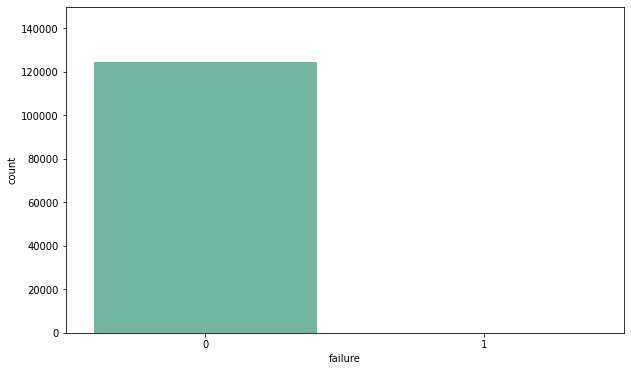

In [112]:
#Check count of failure
plt.figure(figsize=(10,6))
sns.countplot(df['failure'],palette='Set2')
plt.ylim(0,150000)
#plt.savefig('Images//1.Unsampled_Label.jpeg',dpi=300)
plt.show()
#As we can see the failure is highly imbalanced

In [39]:
df['failure'].value_counts()

0    124387
1       106
Name: failure, dtype: int64

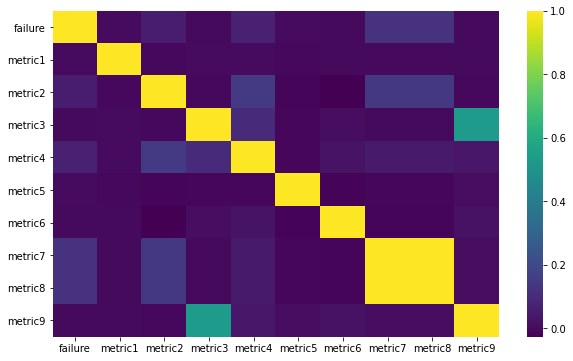

In [40]:
#Plot heatmap to check correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap='viridis')
#plt.savefig('Images//2.Correlation_Heatmap.jpeg',dpi=300)
plt.show()

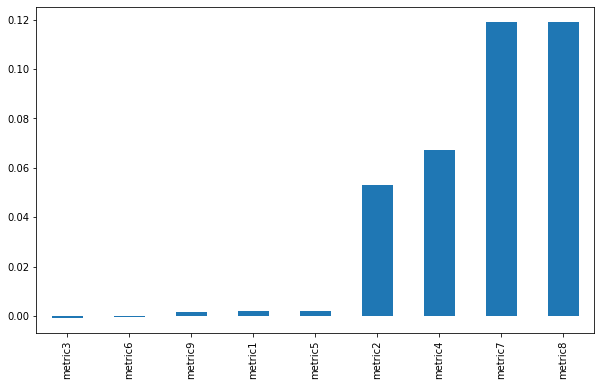

In [42]:
#Plot barplot to check correlation
plt.figure(figsize=(10,6))
df.corr()['failure'].drop('failure').sort_values().plot(kind='bar')
#plt.savefig('Images//3.Correlation_Barplot.jpeg',dpi=300)
plt.show()

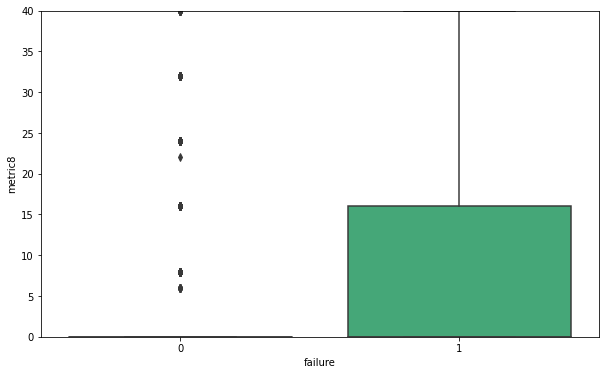

In [45]:
#Plot boxplot to check relation
plt.figure(figsize=(10,6))
sns.boxplot(x='failure',y='metric8',data=df,palette='viridis')
plt.ylim(0,20)
#plt.savefig('Images//4.Box_Plot.jpeg',dpi=300)
plt.show()

In [46]:
#Check Skewness and Detect Outlier
q1=df.quantile(q=0.25)
q3=df.quantile(q=0.75)

In [48]:
#Create IQR Range
IQR=q3-q1
lower_bound = q1 - 1.5*IQR
higer_bound = q3 + 1.5*IQR

In [50]:
higer_bound

failure            0.0
metric1    366347536.0
metric2            0.0
metric3            0.0
metric4            0.0
metric5           18.0
metric6       443487.0
metric7            0.0
metric8            0.0
metric9            0.0
dtype: float64

In [52]:
#Create function for Outlier Detection
def remove_outlier(df,col,inp):
    if inp==False:
        df_copy=df.copy()
        raw=df_copy[col].shape[0]
        df_copy=df_copy[(df_copy[col]>=lower_bound[col]) & (df_copy[col]<=higer_bound[col])]
        prcsd=df_copy[col].shape[0]
        
        percent_change=(((raw-prcsd)/raw)*100)
        outliers=raw-prcsd
        
        print("{} outliers are detected for column {} with percent change being {}".format(outliers,col,percent_change))
    elif inp==True:
        raw=df[col].shape[0]
        df=df[(df[col]>=lower_bound[col]) & (df[col]<=higer_bound[col])]
        prcsd=df[col].shape[0]
        
        percent_change=(((raw-prcsd)/raw)*100)
        outliers=raw-prcsd
        
        print("{} outliers are detected for column {} with percent change being {}".format(outliers,col,percent_change))

In [53]:
#Run Function for each column
for x in df.columns:
    remove_outlier(df,str(x),False)

106 outliers are detected for column failure with percent change being 0.08514534953772501
0 outliers are detected for column metric1 with percent change being 0.0
6384 outliers are detected for column metric2 with percent change being 5.127999164611665
9135 outliers are detected for column metric3 with percent change being 7.3377619625199815
9338 outliers are detected for column metric4 with percent change being 7.50082333946487
14141 outliers are detected for column metric5 with percent change being 11.358871583141221
14392 outliers are detected for column metric6 with percent change being 11.560489344782438
1458 outliers are detected for column metric7 with percent change being 1.1711501851509722
1458 outliers are detected for column metric8 with percent change being 1.1711501851509722
27136 outliers are detected for column metric9 with percent change being 21.797209481657603


In [55]:
#Since we cannot lose more than 7-8% of the data we will not drop any of these columns

In [58]:
pt=PowerTransformer()
for x in df.columns.drop('failure'):
    if abs(df.loc[:,x].skew())>0.55:
        df.loc[:,x]=pt.fit_transform(df.loc[:,x].values.reshape(-1,1))

In [59]:
df.skew()

failure    34.227056
metric1    -0.011127
metric2     4.068813
metric3     3.272988
metric4     3.227063
metric5    -0.301303
metric6    -0.375295
metric7     9.077444
metric8     9.077444
metric9     1.422392
dtype: float64

In [61]:
df1 = df.copy()

In [62]:
#Resample the data as it is highly imbalanced
df1_minority=df1[df1['failure']==1]
df1_majority=df1[df1['failure']==0]

df1_minority_upsampled=resample(df1_minority,replace=True,n_samples=30000,random_state=101)

df1_upsampled=pd.concat([df1_majority,df1_minority_upsampled],axis=0)

In [63]:
df1_minority=df1_upsampled[df1_upsampled['failure']==1]
df1_majority=df1_upsampled[df1_upsampled['failure']==0]

df1_majority_downsampled=resample(df1_majority,replace=False,n_samples=85000,random_state=101)

df1_downsampled=pd.concat([df1_minority,df1_majority_downsampled],axis=0)

In [ ]:
#As the data is expensive we cannot afford to loose more than 7-8% of data so we cannot directly downsample data to make the class balanced
#Also, we cannot upsample the data from 25000 to 150000 as it would lead to many redundant data
#Hence we have only downsampled 6-7% of data and we have upsampled that downsampled data.

In [65]:
#Check resmapled data
df1_downsampled['failure'].value_counts()

0    85000
1    30000
Name: failure, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


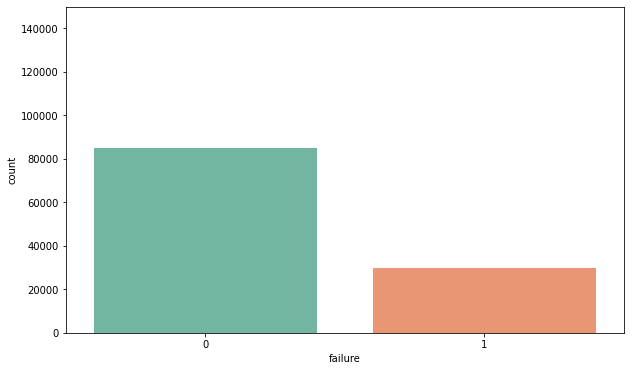

In [68]:
#Check count of Label
plt.figure(figsize=(10,6))
sns.countplot(df1_downsampled['failure'],palette='Set2')
plt.ylim(0,150000)
#plt.savefig('Images//5.Sampled_Data.jpeg',dpi=300)
plt.show()
#As we can see now the data is enough balanced to train a model

In [69]:
vif_df=pd.DataFrame()
vif_df['Features']=df1_downsampled.columns
vif_df['VIF']=[variance_inflation_factor(df1_downsampled.values,x) for x in range(len(df1_downsampled.columns))]

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [70]:
vif_df.sort_values(by='VIF')

,Features,VIF
5,metric5,1.017677
3,metric3,1.149748
9,metric9,1.149872
2,metric2,1.523537
4,metric4,1.737304
0,failure,2.562992
1,metric1,2.959007
6,metric6,3.021608
7,metric7,inf
8,metric8,inf


In [72]:
df_downsampled_copy=df1_downsampled.copy()

In [73]:
df_downsampled_copy=df_downsampled_copy.drop(['metric7','metric8'],axis=1)

In [74]:
df_downsampled_copy.shape

(115000, 8)

In [77]:
#Scale data
scale=MinMaxScaler()
X=df_downsampled_copy.drop('failure',axis=1)
y=df_downsampled_copy['failure']

In [78]:
X=scale.fit_transform(X)

In [79]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [80]:
#Create Function which will evaluate model's performance
model_list=[]
score_list=[]
def model_sel(mod):
    model=mod
    model.fit(X_train,y_train)
    predict=model.predict(X_test)
    f1score=f1_score(y_test,predict)
    model_list.append(str(mod))
    score_list.append(round(f1score,3))
    print("****************** Metrics *********************")
    print()
    print("Accuracy of the model is {}".format(accuracy_score(y_test,predict)))
    print("Recall of the model is {}".format(recall_score(y_test,predict)))
    print("Precision of the model is {}".format(precision_score(y_test,predict)))
    print("F1 score of the model is {}".format(f1score))
    print()
    print("************** Confusion Matrix ****************")
    print()
    print(confusion_matrix(y_test,predict))
    print()
    print("*********** Classification Report **************")
    print()
    print(classification_report(y_test,predict))

In [81]:
#Run model for Logistic Regression
model_sel(LogisticRegression(max_iter=30000))

****************** Metrics *********************

Accuracy of the model is 0.8466666666666667
Recall of the model is 0.6432155201248746
Precision of the model is 0.7340628578699581
F1 score of the model is 0.6856429759923937

************** Confusion Matrix ****************

[[23441  2090]
 [ 3200  5769]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     25531
           1       0.73      0.64      0.69      8969

    accuracy                           0.85     34500
   macro avg       0.81      0.78      0.79     34500
weighted avg       0.84      0.85      0.84     34500



In [82]:
#Run Model for RandomForestClassifier
model_sel(RandomForestClassifier())

****************** Metrics *********************

Accuracy of the model is 0.9995942028985507
Recall of the model is 1.0
Precision of the model is 0.9984415006122677
F1 score of the model is 0.9992201426024955

************** Confusion Matrix ****************

[[25517    14]
 [    0  8969]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25531
           1       1.00      1.00      1.00      8969

    accuracy                           1.00     34500
   macro avg       1.00      1.00      1.00     34500
weighted avg       1.00      1.00      1.00     34500



In [83]:
#Run Model for AdaBoostClassifier
model_sel(AdaBoostClassifier())

****************** Metrics *********************

Accuracy of the model is 0.8773623188405797
Recall of the model is 0.641320102575538
Precision of the model is 0.8501330180313331
F1 score of the model is 0.7311089926914521

************** Confusion Matrix ****************

[[24517  1014]
 [ 3217  5752]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     25531
           1       0.85      0.64      0.73      8969

    accuracy                           0.88     34500
   macro avg       0.87      0.80      0.83     34500
weighted avg       0.88      0.88      0.87     34500



In [90]:
#Run Model for Support Vector Machines
model_sel(SVC())

****************** Metrics *********************

Accuracy of the model is 0.8770434782608696
Recall of the model is 0.717582785148846
Precision of the model is 0.7901780233271946
F1 score of the model is 0.7521327568072922

************** Confusion Matrix ****************

[[23822  1709]
 [ 2533  6436]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     25531
           1       0.79      0.72      0.75      8969

    accuracy                           0.88     34500
   macro avg       0.85      0.83      0.84     34500
weighted avg       0.87      0.88      0.88     34500



In [85]:
#Run Model for KNeighbors
model_sel(KNeighborsClassifier())

****************** Metrics *********************

Accuracy of the model is 0.9971884057971014
Recall of the model is 1.0
Precision of the model is 0.9893006838738142
F1 score of the model is 0.9946215691710563

************** Confusion Matrix ****************

[[25434    97]
 [    0  8969]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25531
           1       0.99      1.00      0.99      8969

    accuracy                           1.00     34500
   macro avg       0.99      1.00      1.00     34500
weighted avg       1.00      1.00      1.00     34500



In [87]:
#Create XGboost Dataset
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

#Create Parameters for XGboost
param = {
    'eta': 0.6, 
    'max_depth': 30,  
    'objective': 'multi:softprob',  
    'num_class': 3}
steps = 80  # The number of training iterations

#Train the model
model = xgb.train(param, D_train, steps)

#Perform Prediction
preds = model.predict(D_test)

#Choose best Prediction
best_preds = np.asarray([np.argmax(line) for line in preds])

print("****************** Metrics *********************")
print()
print("Accuracy of the model is {}".format(accuracy_score(y_test,best_preds)))
print("Recall of the model is {}".format(recall_score(y_test,best_preds)))
print("Precision of the model is {}".format(precision_score(y_test,best_preds)))
print("F1 score of the model is {}".format(f1_score(y_test,best_preds)))
print()
print("************** Confusion Matrix ****************")
print()
print(confusion_matrix(y_test,best_preds))
print()
print("*********** Classification Report **************")
print()
print(classification_report(y_test,best_preds))

model_list.append('XGBoost')
score_list.append(round(f1_score(y_test,best_preds),3))

****************** Metrics *********************

Accuracy of the model is 0.9993043478260869
Recall of the model is 1.0
Precision of the model is 0.9973312576448349
F1 score of the model is 0.9986638458968935

************** Confusion Matrix ****************

[[25507    24]
 [    0  8969]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25531
           1       1.00      1.00      1.00      8969

    accuracy                           1.00     34500
   macro avg       1.00      1.00      1.00     34500
weighted avg       1.00      1.00      1.00     34500



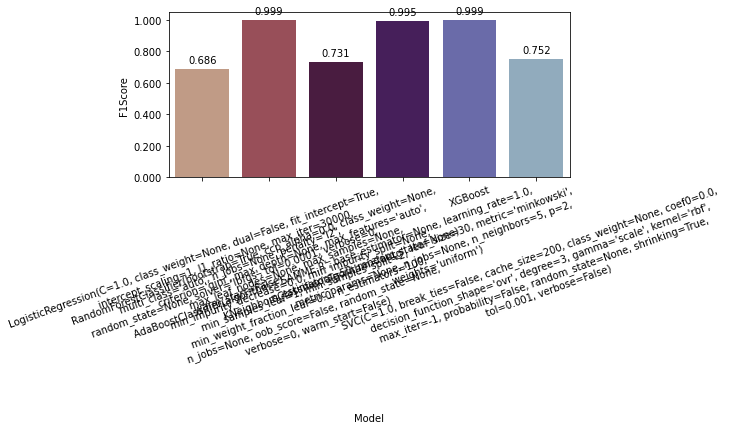

In [91]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
splot=sns.barplot(x=model_list,y=score_list,palette='twilight_r',tick_label=score_list,ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0.00, 9.00), 
                   textcoords = 'offset points')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('Model')
ax.set_ylabel('F1Score')
plt.xticks(rotation=20)
plt.tight_layout()
#plt.savefig('Images//6.Model_Performance.jpeg',dpi=300)
plt.show()

In [ ]:
#From the above graph we can see that RandomForestClassifier is working very well
#So we will try to hypertune its paramters

In [92]:
#Instantiate object for RandomForest to optimize parameters
model=RandomForestClassifier()
model.fit(X_train,y_train)
predict=model.predict(X_test)

In [93]:
cross_val_score(model,X_train,y_train,cv=4).mean()

0.9994906832298137

In [94]:
fpr,tpr,threshold=roc_curve(y_test,predict)
auc(fpr,tpr)

0.9997258235086757

In [95]:
threshold.sort()

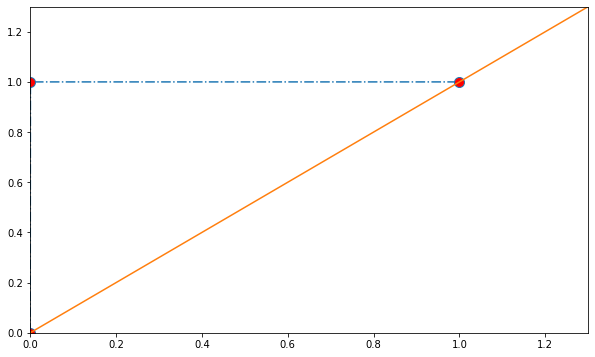

In [96]:
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,marker='o',markerfacecolor='red',markersize=10,linestyle='-.')
plt.plot(threshold)
plt.ylim(0,1.3)
plt.xlim(0,1.3)
#plt.savefig('Images//7.AUC_ROC_Curve.jpeg',dpi=300)
plt.show()

In [97]:
#Hypertune Parameter
params={'n_estimators':[100,130,150,170,190,210,230,250,270,290,310,330]}
gscv=GridSearchCV(model,params)

In [100]:
gscv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [101]:
best_param=gscv.best_params_
best_param['n_estimators']

270

In [102]:
model=RandomForestClassifier(n_estimators=best_param['n_estimators'])
model.fit(X_train,y_train)
predict=model.predict(X_test)

In [103]:
print("****************** Metrics *********************")
print()
print("Accuracy of the model is {}".format(accuracy_score(y_test,predict)))
print("Recall of the model is {}".format(recall_score(y_test,predict)))
print("Precision of the model is {}".format(precision_score(y_test,predict)))
print("F1 score of the model is {}".format(f1_score(y_test,predict)))
print()
print("************** Confusion Matrix ****************")
print()
print(confusion_matrix(y_test,predict))
print()
print("*********** Classification Report **************")
print()
print(classification_report(y_test,predict))

****************** Metrics *********************

Accuracy of the model is 0.9995072463768115
Recall of the model is 1.0
Precision of the model is 0.9981081682617405
F1 score of the model is 0.9990531885268727

************** Confusion Matrix ****************

[[25514    17]
 [    0  8969]]

*********** Classification Report **************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25531
           1       1.00      1.00      1.00      8969

    accuracy                           1.00     34500
   macro avg       1.00      1.00      1.00     34500
weighted avg       1.00      1.00      1.00     34500



In [105]:
df_predict=pd.DataFrame(pd.Series(predict))
df_test=pd.DataFrame(pd.Series(y_test))
df_predict=pd.concat([df_predict.reset_index().drop('index',axis=1),df_test.reset_index().drop('index',axis=1)],axis=1)
df_predict.columns=['Predicted','Original']
df_predict

,Predicted,Original
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
34495,1,1
34496,0,0
34497,1,1
34498,0,0


In [107]:
df_predict.loc[df_predict['Predicted']==df_predict['Original'],'Result']=True
df_predict.loc[df_predict['Predicted']!=df_predict['Original'],'Result']=False

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


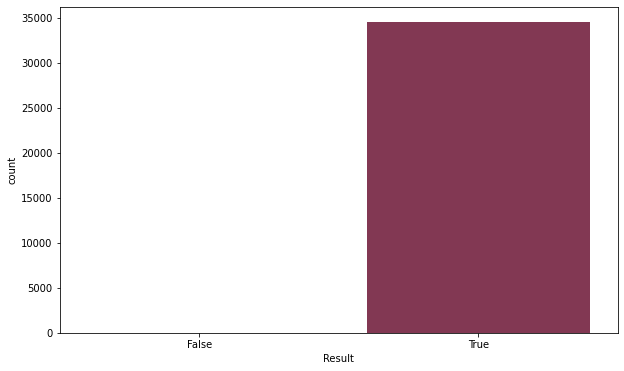

In [108]:
plt.figure(figsize=(10,6))
sns.countplot(df_predict['Result'],palette='twilight')
#plt.savefig('Images//8.Result.jpeg',dpi=300)
plt.show()

In [111]:
joblib.dump(model,'model.obj')

['model.obj']